### Multimodal Embedding

In [43]:
import os
import glob
from pathlib import Path

from typing import List
import oci
import oracledb
import pandas as pd
import base64
import json
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
from dotenv import find_dotenv, load_dotenv

from oci.generative_ai_inference import GenerativeAiInferenceClient
from oci.generative_ai_inference.models import (
    EmbedTextDetails,
    OnDemandServingMode,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.documents import Document
from langchain.callbacks.manager import CallbackManagerForRetrieverRun
from langchain.schema import BaseRetriever
from langchain_community.embeddings import OCIGenAIEmbeddings
from langchain_community.chat_models import ChatOCIGenAI

_ = load_dotenv(find_dotenv())
oracledb.init_oracle_client()

UN = os.getenv("UN")
PW = os.getenv("PW")
DSN = os.getenv("DSN")

OCI_CONFIG_FILE = "~/.oci/config"
OCI_COMPARTMENT_ID = os.getenv("OCI_COMPARTMENT_ID")
OCI_OS_NAMESPACE = os.getenv("OCI_OS_NAMESPACE")
OCI_OS_BUCKET_NAME = os.getenv("OCI_OS_BUCKET_NAME")
OCI_OS_BUCKET_URL = os.getenv("OCI_OS_BUCKET_URL")

config = oci.config.from_file(file_location=OCI_CONFIG_FILE, profile_name="DEFAULT")
generative_ai_inference_client = GenerativeAiInferenceClient(
    config=config,
    service_endpoint="https://inference.generativeai.us-chicago-1.oci.oraclecloud.com"
    )   

In [44]:
# Clear data
images_dir = "../images"

files = glob.glob(os.path.join(images_dir, "*"))

for file in files:
    try:
        os.remove(file)
        print(f"Deleted: {file}")
    except Exception as e:
        print(f"Error deleting {file}: {e}")

print("All files in ../images have been deleted.")

try:
    with oracledb.connect(user=UN, password=PW, dsn=DSN) as conn:
        with conn.cursor() as cursor:
            cursor.execute("TRUNCATE TABLE multimodal_contents")
            print("cleared table multimodal_contents")
        conn.commit()
        print("End Clearing Tables")
except Exception as e:
    print("Error clearing table data:", e)

All files in ../images have been deleted.
cleared table multimodal_contents
End Clearing Tables


In [45]:
def get_embedding(text: str) -> list:
  embeddings = OCIGenAIEmbeddings(
    model_id="cohere.embed-multilingual-v3.0",
    service_endpoint="https://inference.generativeai.us-chicago-1.oci.oraclecloud.com",
    compartment_id=OCI_COMPARTMENT_ID,
  )
  return embeddings.embed_query(text)

In [46]:
with open('../../data/appliances.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
    
appliances = data['electrical_appliances']
for appliance in appliances:
    detail_text = appliance["detail"]
    embedding_vector = get_embedding(detail_text)
    appliance["embedding"] = embedding_vector
print(f"Number of appliances: {len(appliances)}")

try:
    with oracledb.connect(user=UN, password=PW, dsn=DSN) as conn:
        cur = conn.cursor()
        for appliance in appliances:
            cur.execute("""
                INSERT INTO multimodal_contents (name, summary, content_type, embedding)
                VALUES (:name, :summary, :content_type, :embedding)
            """, {
                "name": appliance["name"],
                "summary": appliance["detail"],
                "content_type": "text",
                "embedding": str(appliance["embedding"])
            })
        conn.commit()
        print("Data inserted successfully.")
        cur.close()
        conn.close()
except oracledb.DatabaseError as e:
    error, = e.args
    print("Oracle-Error-Code:", error.code)
    print("Oracle-Error-Message:", error.message)

Number of appliances: 10
Data inserted successfully.


In [47]:
def get_image_embedding(image_path: str):
  with open("../../" + image_path, "rb") as img_file:
    image_data = base64.b64encode(img_file.read()).decode("utf-8")
    data_uri = f"data:image/png;base64,{image_data}"

  model_id = "cohere.embed-multilingual-image-v3.0"
  embed_image_detail = EmbedTextDetails()
  embed_image_detail.serving_mode = OnDemandServingMode(model_id=model_id)
  embed_image_detail.compartment_id = OCI_COMPARTMENT_ID

  embed_image_detail.inputs = [data_uri]
  embed_image_detail.input_type = "IMAGE"
  embedding = generative_ai_inference_client.embed_text(embed_image_detail)
  return embedding.data.embeddings[0]

In [48]:
def insert_image_content(file_name, image_path, image_url, embedding):
    sql = """
        INSERT INTO multimodal_contents (name, image_url, content_type, embedding, image_blob)
        VALUES (:name, :image_url, :content_type, :embedding, empty_blob())
        returning image_blob into :blobdata
        """
    
    try:
        with oracledb.connect(user=UN, password=PW, dsn=DSN) as conn:
            with conn.cursor() as cursor:
                blobdata = cursor.var(oracledb.DB_TYPE_BLOB)
                params = {
                    'name': file_name,
                    'image_url': image_url,
                    'content_type': "image",
                    'embedding': str(embedding),
                    'blobdata': blobdata
                }
                cursor.execute(sql, params)
                blob, = blobdata.getvalue()
                offset = 1
                bufsize = 65536
                with open(image_path, 'rb') as f:
                    while True:
                        data = f.read(bufsize)
                        if data:
                            blob.write(data, offset)
                        if len(data) < bufsize:
                            break
                        offset += bufsize
                print(f"Inserted image content for {file_name} into database.")
            conn.commit()
    except oracledb.DatabaseError as e:
        error, = e.args
        print(f"Error at save_content")
        print(f"Oracle error code: {error.code}")
        print(f"Oracle error message: {error.message}")

In [49]:
images_dir = "../../images/appliances"

# Get list of all image files with common image extensions
image_files = []
for ext in ["*.jpg", "*.jpeg", "*.png", "*.gif"]:
    image_files.extend(glob.glob(os.path.join(images_dir, ext)))

print(f"Found {len(image_files)} image files in {images_dir}")
    
for image_path in image_files:
    try:
        rel_path = os.path.relpath(image_path, "../../")
        print(f"Relative path: {rel_path}")

        filename = Path(image_path).stem
        print(f"Processing image: {filename}")
        image_embedding = get_image_embedding(rel_path)

        insert_image_content(
            file_name=filename,
            image_path=image_path,
            image_url=f"{rel_path}",
            embedding=image_embedding
        )
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

Found 4 image files in ../../images/appliances
Relative path: images/appliances/refrigerator.png
Processing image: refrigerator
Inserted image content for refrigerator into database.
Relative path: images/appliances/rice_cooker.png
Processing image: rice_cooker
Inserted image content for rice_cooker into database.
Relative path: images/appliances/TV.png
Processing image: TV
Inserted image content for TV into database.
Relative path: images/appliances/washing_machine.png
Processing image: washing_machine
Inserted image content for washing_machine into database.


In [61]:
def get_multimodal_content_by_vector_search(query_text: str):
    contents = []
    embed_query = str(get_embedding(query_text))

    try:
        with oracledb.connect(user=UN, password=PW, dsn=DSN) as connection:
            with connection.cursor() as cursor:
                cursor.setinputsizes(oracledb.DB_TYPE_VECTOR)
                select_sql = f"""
                    SELECT
                        id,
                        name,
                        content_type,
                        summary
                    FROM
                        multimodal_contents
                    ORDER BY VECTOR_DISTANCE(embedding, to_vector(:1, 1024, FLOAT32), COSINE)
                    FETCH FIRST 3 ROWS ONLY
                """
                cursor.execute(select_sql, [embed_query])
                index = 1
                for row in cursor:
                    content = {
                        'id': row[0],
                        'name': row[1],
                        'content_type': row[2],
                        'summary': row[3],
                        'vector_index': index
                    }
                    contents.append(content)
                    index += 1
                # connection.commit()
            connection.close()
                    
    except oracledb.DatabaseError as e:
        print(f"Database error: {e}")
        raise
    except Exception as e:
        print("Error Vector Search:", e)

    print(f"Found {len(contents)} multimodal contents")
    print(f"Contents: {contents}")
    for content in contents:
        if content['content_type'] == 'image':
            print(f"Image Content: {content['name']}")

            try:
                with oracledb.connect(user=UN, password=PW, dsn=DSN) as connection:
                    with connection.cursor() as cursor:
                        select_sql = f"""
                            SELECT
                                image_blob
                            FROM
                                multimodal_contents
                            WHERE
                                id = :1
                        """
                        cursor.execute(select_sql, [content['id']])
                        blob, = cursor.fetchone()
                        offset = 1
                        bufsize = 65536
                        with open('../images/tmp_image'+str(content['id'])+'.png', 'wb') as f:
                            while True:
                                data = blob.read(offset, bufsize)
                                if data:
                                    f.write(data)
                                if len(data) < bufsize:
                                    break
                                offset += bufsize
                    connection.close()
                            
            except oracledb.DatabaseError as e:
                print(f"Database error: {e}")
                raise
            except Exception as e:
                print("Error SELECT Image:", e)
    return contents

In [63]:
results = get_multimodal_content_by_vector_search("What is the best washing machine?")
print(f"Results: {results}")

Found 3 multimodal contents
Contents: [{'id': 90, 'name': 'washing_machine', 'content_type': 'image', 'summary': None, 'vector_index': 1}, {'id': 78, 'name': 'WashPro 8.5kg 前開き式洗濯機', 'content_type': 'text', 'summary': '8.5kgの洗濯容量で、一度にたくさんの洗濯物を洗える前開き式の洗濯機。コットン、ウール、お急ぎ洗いなど多彩な洗濯コースを搭載し、水も電力も節約。静音モーターやチャイルドロック機能も備え、安心して使えます。', 'vector_index': 2}, {'id': 83, 'name': 'DustAway V10 コードレス掃除機', 'content_type': 'text', 'summary': '軽量&コードレスで家中どこでも楽に掃除ができるスティック型掃除機です。強力な吸引力とHEPAフィルターを備え、ほこりやアレル物質をしっかり除去。最大45分の連続運転が可能で、床・カーペット・家具にも対応。', 'vector_index': 3}]
Image Content: washing_machine
Results: [{'id': 90, 'name': 'washing_machine', 'content_type': 'image', 'summary': None, 'vector_index': 1}, {'id': 78, 'name': 'WashPro 8.5kg 前開き式洗濯機', 'content_type': 'text', 'summary': '8.5kgの洗濯容量で、一度にたくさんの洗濯物を洗える前開き式の洗濯機。コットン、ウール、お急ぎ洗いなど多彩な洗濯コースを搭載し、水も電力も節約。静音モーターやチャイルドロック機能も備え、安心して使えます。', 'vector_index': 2}, {'id': 83, 'name': 'DustAway V10 コードレス掃除機', 'content_type': 'text', 'summary': '軽量&コードレスで家中どこでも楽に掃除ができる


==== RESULT 1 ====

Content Type: IMAGE
Displaying image: washing_machine - Saved to: ../images/tmp_image90.png


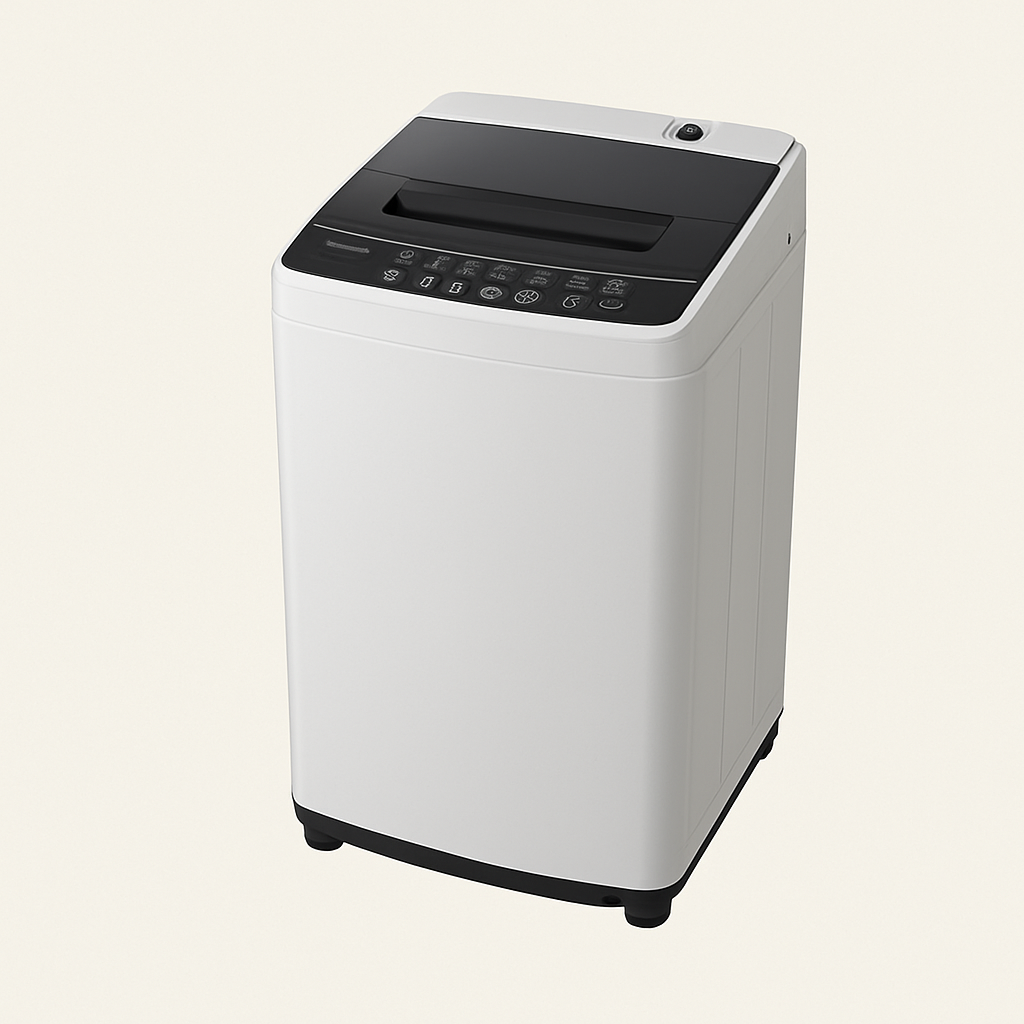


==== RESULT 2 ====

Content Type: TEXT
WashPro 8.5kg 前開き式洗濯機: 8.5kgの洗濯容量で、一度にたくさんの洗濯物を洗える前開き式の洗濯機。コットン、ウール、お急ぎ洗いなど多彩な洗濯コースを搭載し、水も電力も節約。静音モーターやチャイルドロック機能も備え、安心して使えます。

==== RESULT 3 ====

Content Type: TEXT
DustAway V10 コードレス掃除機: 軽量&コードレスで家中どこでも楽に掃除ができるスティック型掃除機です。強力な吸引力とHEPAフィルターを備え、ほこりやアレル物質をしっかり除去。最大45分の連続運転が可能で、床・カーペット・家具にも対応。


In [71]:
for idx, result in enumerate(results):
    print(f"\n==== RESULT {idx + 1} ====\n")
    if result['content_type'] == 'text':
        print("Content Type: TEXT")
        print(f"{result['name']}: {result['summary']}")
    elif result['content_type'] == 'image':
        print("Content Type: IMAGE")
        image_path = f"../images/tmp_image{result['id']}.png"
        print(f"Displaying image: {result['name']} - Saved to: {image_path}")
        display(Image(filename=image_path, width=300, height=300))
